# Glider Data Generation

Generated Slocum Glider Transect Data (First 10 rows):
                 Date & Time  Depth (m)  Pitch (deg)
0 2025-05-22 22:54:23.769361   0.000000    -0.919332
1 2025-05-22 22:54:33.769361   0.003761    -0.249783
2 2025-05-22 22:54:43.769361   0.015043    -3.041217
3 2025-05-22 22:54:53.769361   0.033846    -4.251309
4 2025-05-22 22:55:03.769361   0.060170     0.243779
5 2025-05-22 22:55:13.769361   0.094015    -3.525379
6 2025-05-22 22:55:23.769361   0.135379    -3.092009
7 2025-05-22 22:55:33.769361   0.184263    -1.316061
8 2025-05-22 22:55:43.769361   0.240666    -0.699184
9 2025-05-22 22:55:53.769361   0.304586    -2.503222

Generated Slocum Glider Transect Data (Last 10 rows):
                    Date & Time   Depth (m)  Pitch (deg)
2510 2025-05-23 05:52:43.769361  976.123943    17.124410
2511 2025-05-23 05:52:53.769361  975.528258    18.909564
2512 2025-05-23 05:53:03.769361  974.925420    18.635696
2513 2025-05-23 05:53:13.769361  974.315438    17.039319
2514 2025-05-23 05:53:

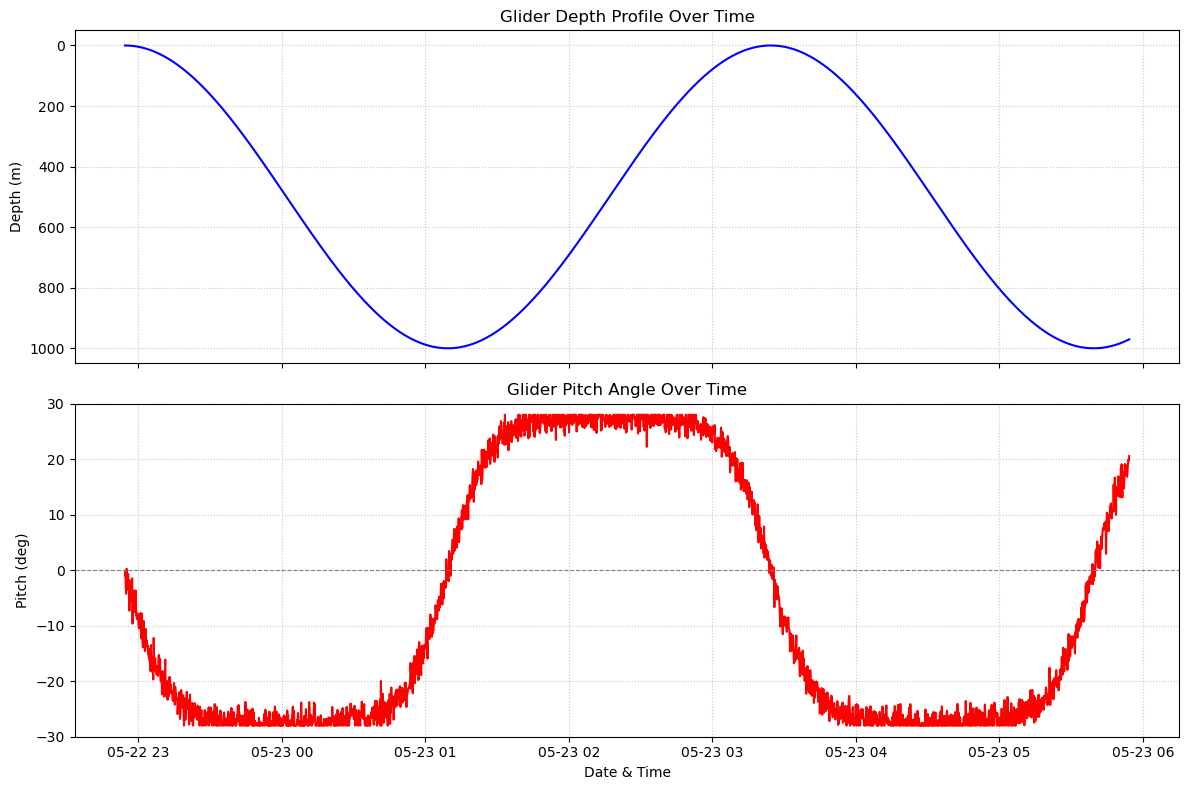

In [24]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def generate_slocum_glider_data(
    start_time=datetime.now(),
    total_hours=7,
    sampling_interval_s=10,
    max_depth_m=1000,
    max_pitch_deg=28,
    yo_duration_hours=4 # Duration for one full dive + ascent cycle
):
    """
    Generates a dummy Slocum glider transect dataset.

    Args:
        start_time (datetime): The starting date and time for the dataset.
        total_hours (float): Total duration of the dataset in hours.
        sampling_interval_s (int): Data sampling interval in seconds.
        max_depth_m (int): Maximum depth the glider reaches in meters.
        max_pitch_deg (int): Maximum absolute pitch angle in degrees.
        yo_duration_hours (float): Duration of one complete dive (down and up) in hours.

    Returns:
        pd.DataFrame: A DataFrame containing 'Date & Time', 'Depth (m)', and 'Pitch (deg)'.
    """
    total_seconds = int(total_hours * 3600)
    num_points = total_seconds // sampling_interval_s

    times = [start_time + timedelta(seconds=i * sampling_interval_s) for i in range(num_points)]
    
    depths = np.zeros(num_points)
    pitches = np.zeros(num_points)

    yo_duration_s = yo_duration_hours * 3600
    points_per_yo = yo_duration_s // sampling_interval_s

    current_time_in_cycle = 0
    current_depth = 0.0
    
    # Glider parameters for realistic movement (simplified)
    # These are very rough and for dummy data only
    vertical_speed_factor_dive = max_depth_m / (yo_duration_s / 2) # m/s for full dive
    vertical_speed_factor_climb = max_depth_m / (yo_duration_s / 2) * 0.8 # Slower climb

    for i in range(num_points):
        # Determine position within the current yo cycle
        time_in_current_yo = (i * sampling_interval_s) % yo_duration_s
        
        # --- Simulate Depth ---
        if time_in_current_yo <= yo_duration_s / 2: # Dive phase
            # Depth increases from 0 to max_depth
            depth_progress = time_in_current_yo / (yo_duration_s / 2)
            current_depth = depth_progress * max_depth_m
            # Smooth in/out of the extremes using a tanh-like curve or sinusoidal segment
            depths[i] = max_depth_m / 2 * (1 - np.cos(depth_progress * np.pi))
            
        else: # Ascent phase
            # Depth decreases from max_depth to 0
            time_in_ascent_phase = time_in_current_yo - (yo_duration_s / 2)
            depth_progress = time_in_ascent_phase / (yo_duration_s / 2)
            current_depth = max_depth_m - (depth_progress * max_depth_m)
            # Smooth in/out
            depths[i] = max_depth_m / 2 * (1 + np.cos(depth_progress * np.pi))
            
        # Ensure depth is within 0-max_depth bounds due to floating point and smoothing
        depths[i] = np.clip(depths[i], 0, max_depth_m)

        # --- Simulate Pitch based on Depth Change (or phase of yo) ---
        # Pitch should be negative during dive, positive during ascent
        # We can use a sine wave shifted to fit pitch range, or a more direct mapping.
        
        # Determine the phase of the yo for pitch calculation
        phase_in_yo = time_in_current_yo / yo_duration_s
        
        # Pitch profile: start near 0, go to -max, then cross 0 at bottom, go to +max, then cross 0 at top
        # Using a sine wave that goes from 0 -> -1 -> 0 -> 1 -> 0 over a cycle
        pitch_raw = -np.sin(phase_in_yo * 2 * np.pi) * max_pitch_deg

        # Add some realism: steeper pitch for most of the dive/climb, smoother near extremes
        # Using a tanh function to 'flatten' the middle of the pitch curve
        smooth_factor = 2.5 # Adjust for how flat the pitch curve is in the middle
        pitch_value = max_pitch_deg * np.tanh(pitch_raw / max_pitch_deg * smooth_factor)
        
        # Add random noise
        pitch_value += np.random.normal(0, 1.5) # Gaussian noise, std dev 1.5 deg
        
        pitches[i] = np.clip(pitch_value, -max_pitch_deg, max_pitch_deg)

        # Handle the end of the total duration for partial yo
        if i == num_points - 1 and total_hours * 3600 % yo_duration_s != 0:
            # If it's a partial yo, ensure depth doesn't go below 0 unless intended
            # and pitch makes sense for the final phase.
            pass


    df = pd.DataFrame({
        'Date & Time': times,
        'Depth (m)': depths,
        'Pitch (deg)': pitches
    })

    return df

if __name__ == "__main__":
    # Generate the dummy data
    glider_data_df = generate_slocum_glider_data(
        total_hours=7,
        sampling_interval_s=10,
        max_depth_m=1000,
        max_pitch_deg=28,
        yo_duration_hours=4.5 # Example: one full yo takes 4.5 hours
    )

    # Display the first few rows and summary
    print("Generated Slocum Glider Transect Data (First 10 rows):")
    print(glider_data_df.head(10))
    print("\nGenerated Slocum Glider Transect Data (Last 10 rows):")
    print(glider_data_df.tail(10))

    print(f"\nTotal data points: {len(glider_data_df)}")
    print(f"Total duration: {(glider_data_df['Date & Time'].iloc[-1] - glider_data_df['Date & Time'].iloc[0])}")

    # Basic statistics for generated data
    print("\nStatistics for generated data:")
    print(glider_data_df.describe())

    # Optional: Save the data to a CSV file for later use
    output_filename = 'dummy_glider_transect_data.csv'
    glider_data_df.to_csv(output_filename, index=False)
    print(f"\nDummy data saved to '{output_filename}'")

    # Optional: Plot to visualize the generated data
    import matplotlib.pyplot as plt

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    ax1.plot(glider_data_df['Date & Time'], glider_data_df['Depth (m)'], color='blue', lw=1.5)
    ax1.set_ylabel('Depth (m)')
    ax1.set_title('Glider Depth Profile Over Time')
    ax1.grid(True, linestyle=':', alpha=0.7)
    ax1.invert_yaxis() # Depth typically increases downwards

    ax2.plot(glider_data_df['Date & Time'], glider_data_df['Pitch (deg)'], color='red', lw=1.5)
    ax2.set_xlabel('Date & Time')
    ax2.set_ylabel('Pitch (deg)')
    ax2.set_title('Glider Pitch Angle Over Time')
    ax2.axhline(0, color='gray', linestyle='--', lw=0.8) # Line for 0 pitch
    ax2.set_ylim(-30, 30) # Ensure pitch limits are visible
    ax2.grid(True, linestyle=':', alpha=0.7)

    plt.tight_layout()
    plt.show()

In [25]:
data_file_path = 'dummy_glider_transect_sawtooth_depth_only_data.csv' # <--- MODIFY THIS LINE IF YOUR FILE IS DIFFERENT


Error loading real data: Data file not found at: dummy_glider_transect_sawtooth_depth_only_data.csv
Falling back to generating DUMMY DATA for demonstration.
Generated 360 dummy data points.

Starting Slocum Glider Pitch Animation...


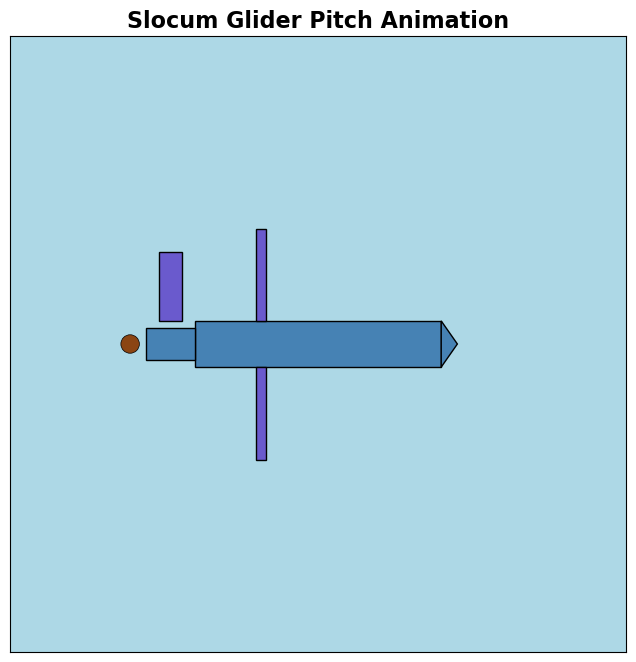

Animation finished.


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as mtransforms
from matplotlib.animation import FuncAnimation
from datetime import datetime
import os

# --- 1. Glider Drawing Function ---
def create_glider_elements(center_x=0, center_y=0, body_length=0.8, body_height=0.15, wing_span=0.6, fin_size=0.15):
    """
    Creates a list of Matplotlib patches representing a simplified Slocum glider
    and returns initial Line2D objects for its local axes.
    The glider is initially horizontal, centered at (center_x, center_y).
    """
    glider_patches = []

    # Main Body (centered horizontally, middle of vertical extent)
    body = patches.Rectangle((center_x - body_length/2, center_y - body_height/2), body_length, body_height, fc='#4682B4', ec='black', lw=1.0) # SteelBlue
    glider_patches.append(body)

    # Nose Cone (triangle at the front)
    nose_points = np.array([
        [center_x + body_length/2, center_y + body_height/2],
        [center_x + body_length/2, center_y - body_height/2],
        [center_x + body_length/2 + body_height/2 * 0.7, center_y] # Pointy nose
    ])
    nose = patches.Polygon(nose_points, closed=True, fc='#4682B4', ec='black', lw=1.0)
    glider_patches.append(nose)

    # Tail Section (smaller rectangle at the back)
    tail_length = body_length * 0.2
    tail_height = body_height * 0.7
    tail = patches.Rectangle((center_x - body_length/2 - tail_length, center_y - tail_height/2), tail_length, tail_height, fc='#4682B4', ec='black', lw=1.0)
    glider_patches.append(tail)

    # Wings (two rectangles, one on each side, relative to body center)
    wing_width = body_height * 0.2
    wing_length = wing_span / 2
    
    # Left Wing
    left_wing_points = np.array([
        [center_x - body_length/4, center_y + body_height/2],
        [center_x - body_length/4 + wing_width, center_y + body_height/2],
        [center_x - body_length/4 + wing_width, center_y + body_height/2 + wing_length],
        [center_x - body_length/4, center_y + body_height/2 + wing_length]
    ])
    left_wing = patches.Polygon(left_wing_points, closed=True, fc='#6A5ACD', ec='black', lw=1.0) # SlateBlue
    glider_patches.append(left_wing)

    # Right Wing (mirrored)
    right_wing_points = np.array([
        [center_x - body_length/4, center_y - body_height/2],
        [center_x - body_length/4 + wing_width, center_y - body_height/2],
        [center_x - body_length/4 + wing_width, center_y - body_height/2 - wing_length],
        [center_x - body_length/4, center_y - body_height/2 - wing_length]
    ])
    right_wing = patches.Polygon(right_wing_points, closed=True, fc='#6A5ACD', ec='black', lw=1.0) # SlateBlue
    glider_patches.append(right_wing)

    # Vertical Fin (at the back)
    v_fin_width = fin_size * 0.5
    v_fin_height = fin_size * 1.5
    v_fin = patches.Rectangle((center_x - body_length/2 - tail_length + tail_length/2 - v_fin_width/2, center_y + body_height/2), v_fin_width, v_fin_height, fc='#6A5ACD', ec='black', lw=1.0)
    glider_patches.append(v_fin)

    # Propeller (small circle at the very back)
    propeller = patches.Circle((center_x - body_length/2 - tail_length - 0.05, center_y), radius=0.03, fc='#8B4513', ec='black', lw=0.5) # SaddleBrown
    glider_patches.append(propeller)

    # --- Local Axes ---
    # These are Line2D objects added to the plot, whose data will be updated
    axis_length = 0.3 # Length of the displayed axes from glider center
    
    # Horizontal axis (line from center to right)
    h_axis_line, = plt.plot([center_x, center_x + axis_length], [center_y, center_y],
                            color='red', linewidth=2, linestyle='-', marker='>', markersize=8,
                            label='Glider Horizontal Axis', zorder=3)
    # Vertical axis (line from center upwards)
    v_axis_line, = plt.plot([center_x, center_x], [center_y, center_y + axis_length],
                            color='green', linewidth=2, linestyle='-', marker='^', markersize=8,
                            label='Glider Vertical Axis', zorder=3)
    
    return glider_patches, [h_axis_line, v_axis_line]

# --- Dummy Data Generator (matches previous sawtooth depth, sinusoidal pitch) ---
def generate_dummy_glider_data_for_animation(
    total_hours=1, # Reduce duration for quick animation demo
    sampling_interval_s=10,
    max_depth_m=1000, # Depth not used for animation directly, but good for context
    max_pitch_deg=28,
    yo_duration_hours=0.5 # Shorter yo for demonstration
):
    """
    Generates dummy Slocum glider transect data suitable for pitch animation.
    This version creates a sawtooth-like depth pattern and a smoother sinusoidal pitch.
    """
    start_time = datetime.now()
    total_seconds = int(total_hours * 3600)
    num_points = total_seconds // sampling_interval_s

    times = [start_time + timedelta(seconds=i * sampling_interval_s) for i in range(num_points)]
    
    depths = np.zeros(num_points)
    pitches = np.zeros(num_points)

    yo_duration_s = int(yo_duration_hours * 3600)
    
    # Half duration of a yo cycle (dive or ascent phase)
    half_yo_s = yo_duration_s / 2
    vertical_speed_mps = max_depth_m / half_yo_s
    
    # Noise parameters
    depth_noise_std = 5 # meters
    pitch_noise_std = 1.5 # degrees

    for i in range(num_points):
        # --- Generate Sawtooth Depth --- (though not directly used in animation, good for completeness)
        time_in_current_yo_s = (i * sampling_interval_s) % yo_duration_s
        if time_in_current_yo_s < half_yo_s: # Dive phase
            current_raw_depth = time_in_current_yo_s * vertical_speed_mps
        else: # Ascent phase
            time_in_ascent_phase = time_in_current_yo_s - half_yo_s
            current_raw_depth = max_depth_m - (time_in_ascent_phase * vertical_speed_mps)
        depths[i] = np.clip(current_raw_depth + np.random.normal(0, depth_noise_std), 0, max_depth_m)
        
        # --- Generate Sinusoidal Pitch ---
        pitch_phase = (i * sampling_interval_s) / yo_duration_s
        pitch_value = -np.sin(pitch_phase * 2 * np.pi) * max_pitch_deg
        
        smooth_factor = 2.5 # Adjust for how flat the pitch curve is in the middle
        pitch_value = max_pitch_deg * np.tanh(pitch_value / max_pitch_deg * smooth_factor)
        
        pitches[i] = np.clip(pitch_value + np.random.normal(0, pitch_noise_std), -max_pitch_deg, max_pitch_deg)


    df = pd.DataFrame({
        'Date & Time': times,
        'Depth (m)': depths, # Included for data consistency
        'Pitch (deg)': pitches
    })

    return df

# --- Main Animation Class ---
class GliderPitchAnimator:
    def __init__(self, data_df):
        self.data = data_df
        self.num_frames = len(self.data)
        
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.set_facecolor('#ADD8E6') # LightBlue background for water

        # Glider will be centered in the view
        self.glider_center_x = 0
        self.glider_center_y = 0

        self.glider_patches, self.axis_lines = create_glider_elements(self.glider_center_x, self.glider_center_y)
        
        # Add all elements to the axes
        for patch in self.glider_patches:
            self.ax.add_patch(patch)
        # Axis lines are already added by plt.plot()

        # Text annotations
        self.datetime_text = self.ax.text(0.02, 0.96, '', transform=self.ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="k", lw=1, alpha=0.7))
        self.pitch_text = self.ax.text(0.02, 0.90, '', transform=self.ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="k", lw=1, alpha=0.7))

        # Set fixed plot limits
        self.ax.set_xlim(-1, 1)
        self.ax.set_ylim(-1, 1)
        self.ax.set_xticks([]) # Hide ticks for a cleaner look
        self.ax.set_yticks([])
        self.ax.set_title('Slocum Glider Pitch Animation', fontsize=16, weight='bold')

        # Artists that will be updated in each frame
        self.animated_artists = self.glider_patches + self.axis_lines + [self.datetime_text, self.pitch_text]

    def init(self):
        """Initializes the animation frame (sets initial state for blitting)."""
        for artist in self.animated_artists:
            artist.set_visible(True) # Ensure all are visible initially
            # Reset any transformations if necessary for the first frame
            if isinstance(artist, (patches.Rectangle, patches.Polygon, patches.Circle)):
                # This ensures they start from their original non-rotated position
                artist.set_transform(self.ax.transData)
            elif isinstance(artist, plt.Line2D):
                artist.set_data([], []) # Clear line data temporarily
        return self.animated_artists

    def update(self, frame):
        """Updates the animation for each frame."""
        if frame >= self.num_frames:
            return self.animated_artists # Stop animation

        current_time_obj = self.data['Date & Time'].iloc[frame]
        current_pitch_deg = self.data['Pitch (deg)'].iloc[frame]

        # Convert pitch to radians for rotation.
        # Positive pitch (nose up) corresponds to counter-clockwise rotation in matplotlib.
        pitch_rad = np.radians(current_pitch_deg)

        # --- Apply Transformation to Glider Patches ---
        # Create a rotation transform centered at the glider's fixed point (0,0)
        # Note: matplotlib's rotate_deg takes degrees, positive is counter-clockwise.
        # If nose up is positive pitch, then +deg means rotate counter-clockwise.
        rotation_transform = mtransforms.Affine2D().rotate_deg(current_pitch_deg) + self.ax.transData
        
        for patch in self.glider_patches:
            # Polygons and Rectangles usually handle transforms well.
            patch.set_transform(rotation_transform)

        # --- Update Local Axes ---
        # Define the local axes relative to the glider's center (0,0) before any rotation
        axis_length = 0.3 # As defined in create_glider_elements

        # Horizontal axis: points from (0,0) to (axis_length, 0) in glider's local frame
        h_local_points = np.array([[0, 0], [axis_length, 0]])
        # Vertical axis: points from (0,0) to (0, axis_length) in glider's local frame
        v_local_points = np.array([[0, 0], [0, axis_length]])

        # Transform these local points using the same rotation
        h_transformed = rotation_transform.transform(h_local_points)
        v_transformed = rotation_transform.transform(v_local_points)

        # Update the Line2D objects with the new transformed coordinates
        self.axis_lines[0].set_data(h_transformed[:, 0], h_transformed[:, 1])
        self.axis_lines[1].set_data(v_transformed[:, 0], v_transformed[:, 1])

        # --- Update Text Annotations ---
        self.datetime_text.set_text(f'Date & Time: {current_time_obj.strftime("%Y-%m-%d %H:%M:%S")}')
        self.pitch_text.set_text(f'Pitch: {current_pitch_deg:.2f}°')

        return self.animated_artists

# --- Main Program Execution ---
if __name__ == "__main__":
    # --- Data Loading Configuration ---
    # 1. Specify the path to your Slocum glider data file.
    #    This should be the CSV file generated from the previous steps (e.g., 'dummy_glider_transect_sawtooth_depth_only_data.csv').
    #    If your file is in the same directory as this script, just use the filename.
    #    Otherwise, provide the full path.
    data_file_path = 'dummy_glider_transect_sawtooth_depth_only_data.csv' # <--- MODIFY THIS LINE IF YOUR FILE IS DIFFERENT

    glider_data = None

    try:
        if os.path.exists(data_file_path):
            print(f"Attempting to load glider data from: {data_file_path}")
            glider_data = pd.read_csv(data_file_path, parse_dates=['Date & Time'])
            
            # --- IMPORTANT: Column Renaming ---
            # Ensure your DataFrame has 'Date & Time' and 'Pitch (deg)' columns.
            # If your columns have different names, rename them here:
            # Example:
            # glider_data = glider_data.rename(columns={
            #     'Your_Timestamp_Column': 'Date & Time',
            #     'Your_Pitch_Angle_Column_in_Degrees': 'Pitch (deg)'
            # })

            # Validate essential columns
            if 'Date & Time' not in glider_data.columns or 'Pitch (deg)' not in glider_data.columns:
                raise ValueError("Missing required columns: 'Date & Time' or 'Pitch (deg)'. "
                                 "Please ensure columns are named correctly or renamed in the script.")
            
            print(f"Successfully loaded {len(glider_data)} data points from file.")
        else:
            raise FileNotFoundError(f"Data file not found at: {data_file_path}")

    except Exception as e:
        print(f"\nError loading real data: {e}")
        print("Falling back to generating DUMMY DATA for demonstration.")
        # If loading fails, generate dummy data for the animation
        glider_data = generate_dummy_glider_data_for_animation()
        print(f"Generated {len(glider_data)} dummy data points.")

    # --- Run the Animation ---
    if glider_data is not None and not glider_data.empty:
        animator = GliderPitchAnimator(glider_data)
        
        # Create the animation object
        # interval: delay between frames in milliseconds (e.g., 50ms = 20 frames/sec)
        # blit=True: optimized drawing, only redraws changed elements. Requires careful handling of return values from init/update.
        ani = FuncAnimation(animator.fig, animator.update, frames=animator.num_frames,
                            init_func=animator.init, blit=True, interval=50, repeat=False) # repeat=False to play once

        print("\nStarting Slocum Glider Pitch Animation...")
        plt.show()
        print("Animation finished.")
    else:
        print("No data available to animate. Exiting.")

Attempting to load glider data from: dummy_glider_transect_data.csv
Successfully loaded 2520 data points from file.

Starting Slocum Glider Pitch Animation (1 second per data point)...


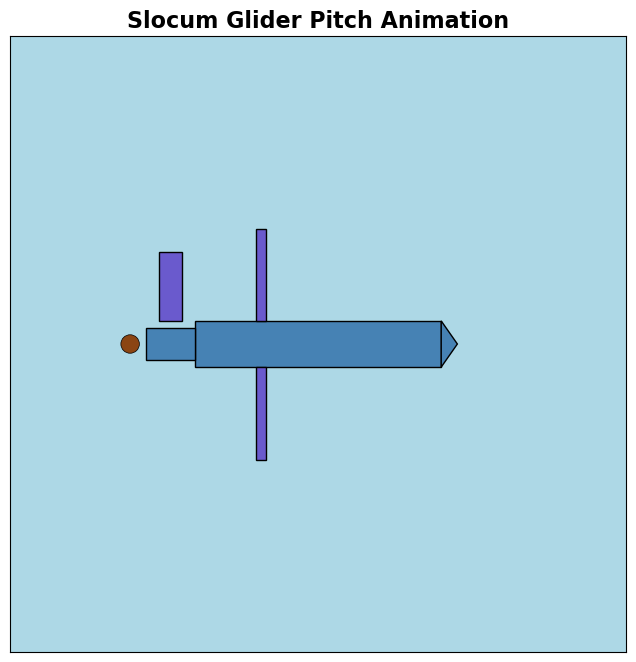

Animation finished.


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.transforms as mtransforms
from matplotlib.animation import FuncAnimation
from datetime import datetime, timedelta
import os

# --- 1. Glider Drawing Function (Same as before) ---
def create_glider_elements(center_x=0, center_y=0, body_length=0.8, body_height=0.15, wing_span=0.6, fin_size=0.15):
    """
    Creates a list of Matplotlib patches representing a simplified Slocum glider
    and returns initial Line2D objects for its local axes.
    The glider is initially horizontal, centered at (center_x, center_y).
    """
    glider_patches = []

    # Main Body (centered horizontally, middle of vertical extent)
    body = patches.Rectangle((center_x - body_length/2, center_y - body_height/2), body_length, body_height, fc='#4682B4', ec='black', lw=1.0) # SteelBlue
    glider_patches.append(body)

    # Nose Cone (triangle at the front)
    nose_points = np.array([
        [center_x + body_length/2, center_y + body_height/2],
        [center_x + body_length/2, center_y - body_height/2],
        [center_x + body_length/2 + body_height/2 * 0.7, center_y] # Pointy nose
    ])
    nose = patches.Polygon(nose_points, closed=True, fc='#4682B4', ec='black', lw=1.0)
    glider_patches.append(nose)

    # Tail Section (smaller rectangle at the back)
    tail_length = body_length * 0.2
    tail_height = body_height * 0.7
    tail = patches.Rectangle((center_x - body_length/2 - tail_length, center_y - tail_height/2), tail_length, tail_height, fc='#4682B4', ec='black', lw=1.0)
    glider_patches.append(tail)

    # Wings (two rectangles, one on each side, relative to body center)
    wing_width = body_height * 0.2
    wing_length = wing_span / 2
    
    # Left Wing
    left_wing_points = np.array([
        [center_x - body_length/4, center_y + body_height/2],
        [center_x - body_length/4 + wing_width, center_y + body_height/2],
        [center_x - body_length/4 + wing_width, center_y + body_height/2 + wing_length],
        [center_x - body_length/4, center_y + body_height/2 + wing_length]
    ])
    left_wing = patches.Polygon(left_wing_points, closed=True, fc='#6A5ACD', ec='black', lw=1.0) # SlateBlue
    glider_patches.append(left_wing)

    # Right Wing (mirrored)
    right_wing_points = np.array([
        [center_x - body_length/4, center_y - body_height/2],
        [center_x - body_length/4 + wing_width, center_y - body_height/2],
        [center_x - body_length/4 + wing_width, center_y - body_height/2 - wing_length],
        [center_x - body_length/4, center_y - body_height/2 - wing_length]
    ])
    right_wing = patches.Polygon(right_wing_points, closed=True, fc='#6A5ACD', ec='black', lw=1.0) # SlateBlue
    glider_patches.append(right_wing)

    # Vertical Fin (at the back)
    v_fin_width = fin_size * 0.5
    v_fin_height = fin_size * 1.5
    v_fin = patches.Rectangle((center_x - body_length/2 - tail_length + tail_length/2 - v_fin_width/2, center_y + body_height/2), v_fin_width, v_fin_height, fc='#6A5ACD', ec='black', lw=1.0)
    glider_patches.append(v_fin)

    # Propeller (small circle at the very back)
    propeller = patches.Circle((center_x - body_length/2 - tail_length - 0.05, center_y), radius=0.03, fc='#8B4513', ec='black', lw=0.5) # SaddleBrown
    glider_patches.append(propeller)

    # --- Local Axes ---
    axis_length = 0.3
    h_axis_line, = plt.plot([center_x, center_x + axis_length], [center_y, center_y],
                            color='red', linewidth=2, linestyle='-', marker='>', markersize=8,
                            label='Glider Horizontal Axis', zorder=3)
    v_axis_line, = plt.plot([center_x, center_x], [center_y, center_y + axis_length],
                            color='green', linewidth=2, linestyle='-', marker='^', markersize=8,
                            label='Glider Vertical Axis', zorder=3)
    
    return glider_patches, [h_axis_line, v_axis_line]

# --- Dummy Data Generator (Same as before, for fallback) ---
def generate_dummy_glider_data_for_animation(
    total_hours=1, # Reduce duration for quick animation demo
    sampling_interval_s=10,
    max_depth_m=1000, # Depth not used for animation directly, but good for context
    max_pitch_deg=28,
    yo_duration_hours=0.5 # Shorter yo for demonstration
):
    """
    Generates dummy Slocum glider transect data suitable for pitch animation.
    This version creates a sawtooth-like depth pattern and a smoother sinusoidal pitch.
    """
    start_time = datetime.now()
    total_seconds = int(total_hours * 3600)
    num_points = total_seconds // sampling_interval_s

    times = [start_time + timedelta(seconds=i * sampling_interval_s) for i in range(num_points)]
    
    depths = np.zeros(num_points)
    pitches = np.zeros(num_points)

    yo_duration_s = int(yo_duration_hours * 3600)
    half_yo_s = yo_duration_s / 2
    vertical_speed_mps = max_depth_m / half_yo_s
    
    depth_noise_std = 5 # meters
    pitch_noise_std = 1.5 # degrees

    for i in range(num_points):
        time_in_current_yo_s = (i * sampling_interval_s) % yo_duration_s
        
        if time_in_current_yo_s < half_yo_s: 
            current_raw_depth = time_in_current_yo_s * vertical_speed_mps
        else:
            time_in_ascent_phase = time_in_current_yo_s - half_yo_s
            current_raw_depth = max_depth_m - (time_in_ascent_phase * vertical_speed_mps)
        depths[i] = np.clip(current_raw_depth + np.random.normal(0, depth_noise_std), 0, max_depth_m)
        
        pitch_phase = (i * sampling_interval_s) / yo_duration_s
        pitch_value = -np.sin(pitch_phase * 2 * np.pi) * max_pitch_deg
        
        smooth_factor = 2.5
        pitch_value = max_pitch_deg * np.tanh(pitch_value / max_pitch_deg * smooth_factor)
        
        pitches[i] = np.clip(pitch_value + np.random.normal(0, pitch_noise_std), -max_pitch_deg, max_pitch_deg)


    df = pd.DataFrame({
        'Date & Time': times,
        'Depth (m)': depths,
        'Pitch (deg)': pitches
    })

    return df

# --- Main Animation Class (Same logic, but now with updated interval) ---
class GliderPitchAnimator:
    def __init__(self, data_df):
        self.data = data_df
        self.num_frames = len(self.data)
        
        self.fig, self.ax = plt.subplots(figsize=(8, 8))
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.set_facecolor('#ADD8E6') # LightBlue background for water

        self.glider_center_x = 0
        self.glider_center_y = 0

        self.glider_patches, self.axis_lines = create_glider_elements(self.glider_center_x, self.glider_center_y)
        
        for patch in self.glider_patches:
            self.ax.add_patch(patch)

        self.datetime_text = self.ax.text(0.02, 0.96, '', transform=self.ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="k", lw=1, alpha=0.7))
        self.pitch_text = self.ax.text(0.02, 0.90, '', transform=self.ax.transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", fc="lightgreen", ec="k", lw=1, alpha=0.7))

        self.ax.set_xlim(-1, 1)
        self.ax.set_ylim(-1, 1)
        self.ax.set_xticks([])
        self.ax.set_yticks([])
        self.ax.set_title('Slocum Glider Pitch Animation', fontsize=16, weight='bold')

        self.animated_artists = self.glider_patches + self.axis_lines + [self.datetime_text, self.pitch_text]

    def init(self):
        """Initializes the animation frame (sets initial state for blitting)."""
        for artist in self.animated_artists:
            artist.set_visible(True)
            if isinstance(artist, (patches.Rectangle, patches.Polygon, patches.Circle)):
                artist.set_transform(self.ax.transData)
            elif isinstance(artist, plt.Line2D):
                artist.set_data([], [])
        return self.animated_artists

    def update(self, frame):
        """Updates the animation for each frame."""
        if frame >= self.num_frames:
            return self.animated_artists

        current_time_obj = self.data['Date & Time'].iloc[frame]
        current_pitch_deg = self.data['Pitch (deg)'].iloc[frame]

        rotation_transform = mtransforms.Affine2D().rotate_deg(current_pitch_deg) + self.ax.transData
        
        for patch in self.glider_patches:
            patch.set_transform(rotation_transform)

        axis_length = 0.3
        h_local_points = np.array([[0, 0], [axis_length, 0]])
        v_local_points = np.array([[0, 0], [0, axis_length]])

        h_transformed = rotation_transform.transform(h_local_points)
        v_transformed = rotation_transform.transform(v_local_points)

        self.axis_lines[0].set_data(h_transformed[:, 0], h_transformed[:, 1])
        self.axis_lines[1].set_data(v_transformed[:, 0], v_transformed[:, 1])

        self.datetime_text.set_text(f'Date & Time: {current_time_obj.strftime("%Y-%m-%d %H:%M:%S")}')
        self.pitch_text.set_text(f'Pitch: {current_pitch_deg:.2f}°')

        return self.animated_artists

# --- Main Program Execution ---
if __name__ == "__main__":
    data_file_path = 'dummy_glider_transect_data.csv' # <--- MODIFY THIS LINE IF YOUR FILE IS DIFFERENT

    glider_data = None

    try:
        if os.path.exists(data_file_path):
            print(f"Attempting to load glider data from: {data_file_path}")
            glider_data = pd.read_csv(data_file_path, parse_dates=['Date & Time'])
            
            if 'Date & Time' not in glider_data.columns or 'Pitch (deg)' not in glider_data.columns:
                raise ValueError("Missing required columns: 'Date & Time' or 'Pitch (deg)'. "
                                 "Please ensure columns are named correctly or renamed in the script.")
            
            print(f"Successfully loaded {len(glider_data)} data points from file.")
        else:
            raise FileNotFoundError(f"Data file not found at: {data_file_path}")

    except Exception as e:
        print(f"\nError loading real data: {e}")
        print("Falling back to generating DUMMY DATA for demonstration.")
        # If loading fails, generate dummy data for the animation
        glider_data = generate_dummy_glider_data_for_animation()
        print(f"Generated {len(glider_data)} dummy data points.")

    if glider_data is not None and not glider_data.empty:
        animator = GliderPitchAnimator(glider_data)
        
        # --- IMPORTANT CHANGE: Set interval to 1000 milliseconds for 1 second per frame ---
        ani = FuncAnimation(animator.fig, animator.update, frames=animator.num_frames,
                            init_func=animator.init, blit=True, interval=1000, repeat=False) # interval=1000 for 1 second delay per frame

        print("\nStarting Slocum Glider Pitch Animation (1 second per data point)...")
        plt.show()
        print("Animation finished.")
    else:
        print("No data available to animate. Exiting.")

Using existing image: sample_image.png


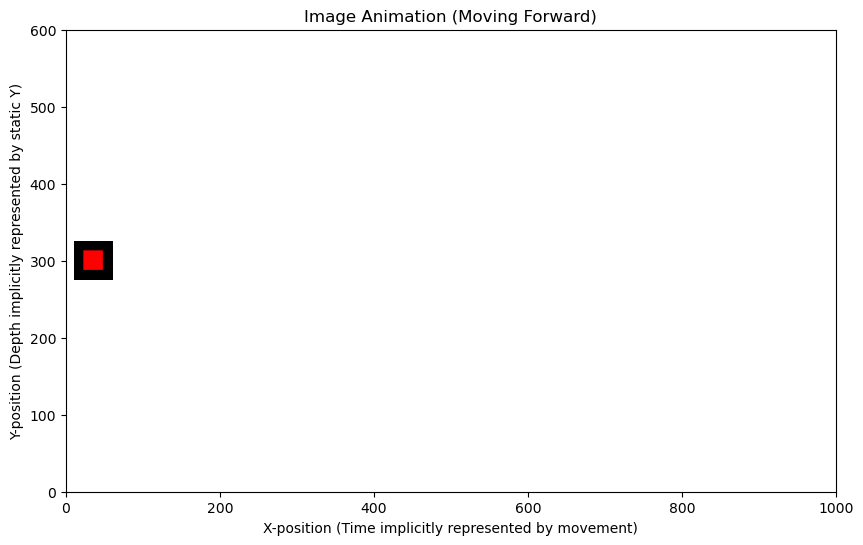

In [29]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import numpy as np
import os

# --- 1. Create a Sample Image (if you don't have one) ---
# This part generates a simple black square image for demonstration.
# You can replace 'sample_image.png' with your own image file.
image_filename = 'sample_image.png'
if not os.path.exists(image_filename):
    print(f"Creating a sample image: {image_filename}")
    img_size = 50  # pixels
    img_array = np.zeros((img_size, img_size, 3), dtype=np.uint8) # Black image
    img_array[img_size//4:3*img_size//4, img_size//4:3*img_size//4] = [255, 0, 0] # Red square in the middle
    sample_img = Image.fromarray(img_array)
    sample_img.save(image_filename)
else:
    print(f"Using existing image: {image_filename}")

# --- 2. Load the Image ---
try:
    img = Image.open(image_filename)
except FileNotFoundError:
    print(f"Error: Image file '{image_filename}' not found.")
    print("Please make sure the image file is in the same directory as the script,")
    print("or provide a full path to your image.")
    exit()

# --- 3. Set up the Figure and Axis ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_aspect('equal') # Maintain aspect ratio
ax.set_xlim(0, 1000)   # X-axis limits (represents the 'world' or screen space)
ax.set_ylim(0, 600)    # Y-axis limits
ax.set_title("Image Animation (Moving Forward)")
ax.set_xlabel("X-position (Time implicitly represented by movement)")
ax.set_ylabel("Y-position (Depth implicitly represented by static Y)")

# Initialize the image plot
# We'll set an initial extent. The image's width and height will be used for 'dx' and 'dy'.
image_width = img.width
image_height = img.height
initial_x_position = 0
initial_y_position = (ax.get_ylim()[1] - image_height) / 2 # Center vertically

# Use imshow to display the image. extent defines the data coordinates for the image corners.
im = ax.imshow(img, extent=[initial_x_position, initial_x_position + image_width,
                             initial_y_position, initial_y_position + image_height])

# --- 4. Animation Function ---
# This function will be called repeatedly by FuncAnimation.
# It updates the position of the image.
x_position = initial_x_position # Current X position of the image's left edge
speed = 5 # Pixels per frame (adjust as needed for smoother/faster movement)

def animate(frame):
    global x_position

    # Move the image in the positive x direction
    x_position += speed

    # If the image goes off screen, reset its position to the left
    if x_position > ax.get_xlim()[1]:
        x_position = ax.get_xlim()[0] - image_width # Start from just off the left edge

    # Update the extent of the image.
    # The extent is [left, right, bottom, top] in data coordinates.
    im.set_extent([x_position, x_position + image_width,
                   initial_y_position, initial_y_position + image_height])

    return [im] # Return the list of artists that were modified

# --- 5. Create and Run the Animation ---
# interval: Delay between frames in milliseconds.
# Here, 10 ms as per your request.
# blit=True: Tells the animation to only redraw the parts of the plot that have changed.
#            This makes the animation more efficient.
ani = animation.FuncAnimation(fig, animate, frames=200, interval=10, blit=True)

plt.show()

# Optional: To save the animation as a GIF or MP4 (requires ffmpeg or imagemagick)
# You might need to install these tools and set the path in matplotlibrc
# ani.save('image_animation.gif', writer='imagemagick', fps=60)
# ani.save('image_animation.mp4', writer='ffmpeg', fps=60)

Using existing image: sample_image.png


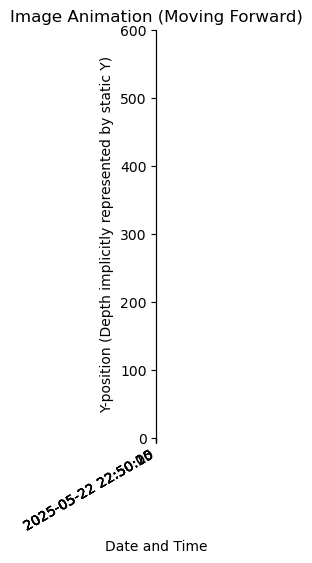

In [30]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from PIL import Image
import numpy as np
import datetime
import matplotlib.dates as mdates
import os

# --- 1. Load the Image ---
# Using the previously generated image
image_filename = 'sample_image.png'
if not os.path.exists(image_filename):
    print(f"Creating a sample image: {image_filename}")
    img_size = 50  # pixels
    img_array = np.zeros((img_size, img_size, 3), dtype=np.uint8) # Black image
    img_array[img_size//4:3*img_size//4, img_size//4:3*img_size//4] = [255, 0, 0] # Red square in the middle
    sample_img = Image.fromarray(img_array)
    sample_img.save(image_filename)
else:
    print(f"Using existing image: {image_filename}")

try:
    img = Image.open(image_filename)
except FileNotFoundError:
    print(f"Error: Image file '{image_filename}' not found.")
    print("Please make sure the image file is in the same directory as the script,")
    print("or provide a full path to your image.")
    exit()

# --- 2. Set up the Figure and Axis ---
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_aspect('equal') # Maintain aspect ratio

# Set up date/time x-axis
start_time = datetime.datetime(2025, 5, 22, 22, 50, 0)  # Example start time
end_time = start_time + datetime.timedelta(seconds=20) # Animation duration
ax.set_xlim(start_time, end_time)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
fig.autofmt_xdate() # Rotate date labels for readability

ax.set_ylim(0, 600)    # Y-axis limits
ax.set_title("Image Animation (Moving Forward)")
ax.set_xlabel("Date and Time")
ax.set_ylabel("Y-position (Depth implicitly represented by static Y)")

# Initialize the image plot
image_width = img.width
image_height = img.height
initial_x_position = start_time
initial_y_position = (ax.get_ylim()[1] - image_height) / 2 # Center vertically

# Use imshow to display the image. extent defines the data coordinates.
# We need to convert the datetime object to a number for extent
im = ax.imshow(img, extent=[mdates.date2num(initial_x_position), mdates.date2num(initial_x_position + datetime.timedelta(seconds=0.1)), # A small time delta for the right edge
                             initial_y_position, initial_y_position + image_height])

# --- 3. Animation Function ---
# This function will be called repeatedly by FuncAnimation.
# It updates the position of the image.
x_position = initial_x_position # Current X position of the image's left edge
speed = 1 # Seconds per frame (adjust as needed)

def animate(frame):
    global x_position

    # Move the image in the positive x direction (time)
    x_position += datetime.timedelta(seconds=speed)

    # If the image goes off screen (time), reset its position
    if x_position > end_time:
        x_position = start_time

    # Update the extent of the image.
    im.set_extent([mdates.date2num(x_position), mdates.date2num(x_position + datetime.timedelta(seconds=0.1)), # Small timedelta for right edge
                   initial_y_position, initial_y_position + image_height])

    return [im] # Return the list of artists that were modified

# --- 4. Create and Run the Animation ---
ani = animation.FuncAnimation(fig, animate, frames=200, interval=10, blit=True)

plt.show()

# Optional: To save the animation as a GIF or MP4
# ani.save('image_animation_datetime.gif', writer='imagemagick', fps=60)
# ani.save('image_animation_datetime.mp4', writer='ffmpeg', fps=60)

In [ ]:
from vpython import *
import numpy as np

# --- 1. Set up the 3D Canvas ---
scene = canvas(title='Sawtooth Wave Visualization',
               width=800, height=500,
               center=vector(5, 0, 0),  # Center the view on the wave
               range=10,                # Zoom level
               background=color.black)

# --- 2. Define Sawtooth Wave Parameters ---
frequency = 1        # Number of cycles in the visible range
amplitude = 1        # Max height of the wave
period = 1 / frequency
num_points = 200     # Number of points to draw the curve
x_max = 10           # Max x-value for the wave

# --- 3. Generate Sawtooth Wave Data ---
# Create an array of x-values
x = np.linspace(0, x_max, num_points)

# Calculate y-values for a sawtooth wave
# The expression (x / period) - floor(x / period) creates a rising ramp from 0 to 1
# This is then scaled by the amplitude and shifted.
y = amplitude * ( (x / period) - np.floor(x / period) )

# --- 4. Create the VPython Curve Object ---
# Initialize an empty curve
sawtooth_curve = curve(color=color.cyan, radius=0.05) # radius gives it thickness

# Add points to the curve
for i in range(num_points):
    sawtooth_curve.append(pos=vector(x[i], y[i], 0))

# --- 5. Add Axes for Better Visualization (Optional) ---
# X-axis
curve(pos=[vector(0, 0, 0), vector(x_max + 1, 0, 0)], color=color.white, radius=0.02)
label(pos=vector(x_max + 1, 0, 0), text='X-axis', xoffset=10, color=color.white)

# Y-axis
curve(pos=[vector(0, 0, 0), vector(0, amplitude + 0.5, 0)], color=color.white, radius=0.02)
label(pos=vector(0, amplitude + 0.5, 0), text='Y-axis', yoffset=10, color=color.white)

# --- 6. Add an "Animation" (or just keep it displayed) ---
# You can make it "animate" by updating properties over time.
# For a static pattern, this loop just keeps the window open.
# If you wanted to, for example, move the wave or change its properties,
# this is where you'd do it.
while True:
    rate(30) # Run at 30 frames per second
    # Example: If you wanted to "scroll" the wave (uncomment to see effect)
    # for pt in sawtooth_curve.points:
    #    pt.pos.x += 0.01
    # Check if a point goes off-screen and wrap it around
    # for i in range(len(sawtooth_curve.points)):
    #     if sawtooth_curve.points[i].pos.x > x_max:
    #         sawtooth_curve.points[i].pos.x -= x_max + 1 # Adjust wrap-around logic as needed
    # sawtooth_curve.modify() # Important to update the curve after changing points

    # For a static wave, this loop just keeps the window alive.

In [40]:
#gdisplay is for displaying the graph 
gdisplay(xtitle = "Time", ytitle = "Amplitude")
my_curve = gcurve(color = color.red, label = "x-co-ord", ) # Plot with datapoints connected
#my_curve = gdots(color = color.red)  # Plot with datapoints NOT connected 

# I want to display the origin of the circle also 
circle_origin = points(pos=[vec(0,0,0)],radius=10, color=color.red)

my_sphere = sphere(pos=vector(0,0,0), radius=0.25, color=color.red, make_trail=True, retain =700, trail_color = vector(0,1,1))
# color = vector() uses RGB code. 


#define a loop to make animation of the sphere
# Definite variables for time 'time' and time step 'dt'

time=0 # Time in simulation
dt=0.01 # Time step size

# while loop starts here
while(time <= 1000):
    rate(100) #Number of frames/loops per second
    #my_sphere.pos.x = my_sphere.pos.x+dx # Dot indicates attribute
    my_sphere.pos.x = cos(time)
    my_sphere.pos.y = sin(time)
    my_curve.plot(pos=(time, my_sphere.pos.x))
    time = time + dt 
# while loop ends here. 

print("End of the program")

NameError: name 'gdisplay' is not defined